# Mask, Generator, Analysis - unet_s256_rings
This notebook reads in images, creates the mask targets, and uses a custom generator to randomly rotate/flip the targets.

It also analyzes the model and loss output for a given run.

In [1]:
import glob
import cv2
import os
import glob
import numpy as np
import pandas as pd
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline 

#import utils.make_density_map_charles as mdm
import utils.make_density_map as mdm

## Preapre data

In [15]:
def get_im_cv2(path, img_width, img_height):
    img = cv2.imread(path)
    #resized = cv2.resize(img, (img_width, img_height))#, cv2.INTER_LINEAR)
    return img

def load_data(path, data_type, img_width, img_height):
    X, X_id, y = [], [], []
    minpix = 2                                  #minimum number of pixels for crater to count
    files = glob.glob('%s*.png'%path)
    minpix, maxpix = 2, 100                          #minimum pixels required for a crater to register in an image
    print "number of %s files are: %d"%(data_type,len(files))
    for f in files:
        flbase = os.path.basename(f)
        img = get_im_cv2(f,img_width,img_height) / 255.
        X.append(img)
        y.append(np.array(Image.open('%smask.tiff'%f.split('.png')[0])))
        
        #csv = pd.read_csv('%s.csv'%f.split('.png')[0])
        #csv = csv[(csv['Diameter (pix)'] < maxpix) & (csv['Diameter (pix)'] > minpix)]
        #target = mdm.make_mask(csv, img, binary=True, truncate=True, rings=True)
        #target = mdm.make_circlering_mask(csv, img, binary=True, truncate=True)
        #target = mdm.make_mask(csv, img, binary=True, rings=True, ringwidth=1, truncate=True)
        #y.append(target)
    return  X, y, X_id

def read_and_normalize_data(path, img_width, img_height, data_flag):
    if data_flag == 0:
        data_type = 'train'
    elif data_flag == 1:
        data_type = 'test'
    data, target, id = load_data(path, data_type, img_width, img_height)
    data = np.array(data).astype('float32')     #convert to numpy, convert to float
    target = np.array(target).astype('float32')
    print('%s shape:'%data_type, data.shape)
    return data, target, id

#save target no border for Hough circles
def save_image(data, cm, fn):
    sizes = np.shape(data)
    height = float(sizes[0])
    width = float(sizes[1])
    fig = plt.figure()
    fig.set_size_inches(width/height, 1, forward=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(data, cmap=cm)
    plt.savefig(fn, dpi = height) 
    
def rescale_and_invcolor(data, inv_color, rescale):
    for img in data:
        if inv_color == 1:
            img[img > 0.] = 1. - img[img > 0.]
        if rescale == 1:
            minn, maxx = np.min(img[img>0]), np.max(img[img>0])
            low, hi = 0.1, 1                                                #low, hi rescaling values
            img[img>0] = low + (img[img>0] - minn)*(hi - low)/(maxx - minn) #linear re-scaling
    return data

#dice coefficient
from keras import backend as K
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [16]:
dim, inv_color, rescale = 256, 1, 1
train_data, train_target, train_id = read_and_normalize_data('datasets/rings/Train_rings/', dim, dim, 0)
test_data, test_target, test_id = read_and_normalize_data('datasets/rings/Test_rings/', dim, dim, 1)

#reshape
train_data = train_data[:,:,:,0].reshape(len(train_data),256,256,1)
test_data = test_data[:,:,:,0].reshape(len(test_data),256,256,1)

#invcolor and rescale
if inv_color==1 or rescale==1:
    train_data = rescale_and_invcolor(train_data, inv_color, rescale)
    test_data = rescale_and_invcolor(test_data, inv_color, rescale)

number of train files are: 20
('train shape:', (20, 256, 256, 3))
number of test files are: 36
('test shape:', (36, 256, 256, 3))


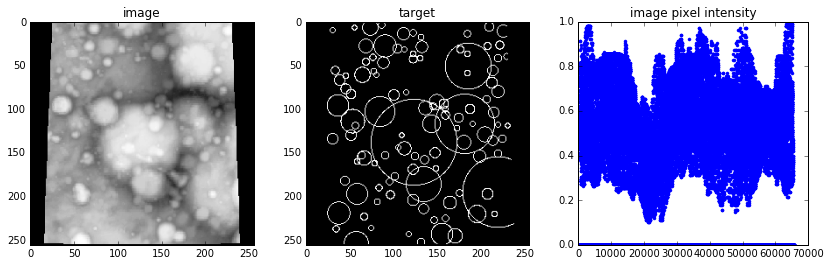

In [4]:
i=0
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=[14, 4])
ax1.imshow(train_data[i].reshape(dim,dim), origin='upper', cmap="Greys_r")
ax1.set_title('image')
ax2.imshow(train_target[i].reshape(dim,dim), origin='upper', cmap="Greys_r")
ax2.set_title('target')
ax3.plot(train_data[i].reshape(dim*dim,1), '.')
ax3.set_title('image pixel intensity')
#ax3.plot(train_target[i].reshape(300*300,1))
#ax3.set_title('original mask')
#plt.savefig("moon_exmask.png")

## Load model and evaluate its performance

In [4]:
from keras.models import load_model

Using TensorFlow backend.


In [13]:
#filename = 'models/FCNforkskip_%s_FL20.h5'%ext
#filename = 'models/FCNforkskip_sigmoidinv_FL10.h5'
#filename = 'models/ds4_sigmoid_FL10.h5'

filename = 'models/unet_s256_rings_copy_glorot_normal.h5'
model = load_model(filename, custom_objects={'dice_coef_loss': dice_coef_loss, 'dice_coef': dice_coef})
#model.summary()

In [ ]:
#do this on external cluster if large file
n,off=32,0
target = model.predict(test_data[off:(n+off)].astype('float32'))

In [8]:
err = np.sum((test_target[off:(n+off)] - target)**2) / (n*300*300)
err

0.01911446533203125

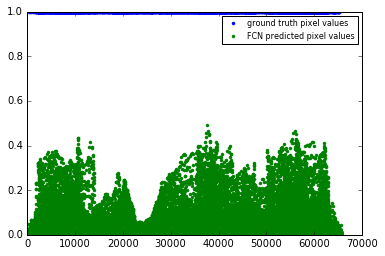

In [9]:
i=0
dim = 256
plt.plot(test_target[off+i].reshape(dim*dim,1), '.', label='ground truth pixel values')
plt.plot(target[i].reshape(dim*dim,1), '.', label='FCN predicted pixel values')
plt.legend(fontsize=8, numpoints=1)
plt.savefig('output_dir/images/%s_%d_pixels.png'%(os.path.basename(filename).split('.h5')[0],i))

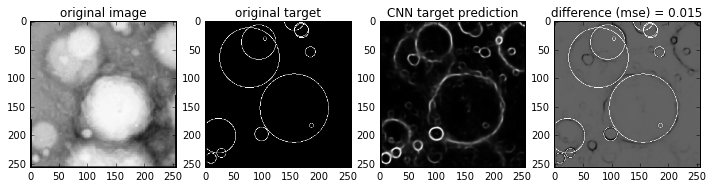

In [14]:
i=4

f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=[12, 8])
ax1.imshow(test_data[off+i].reshape(dim,dim), origin='upper', cmap="Greys_r")
ax2.imshow(test_target[off+i], origin='upper', cmap="Greys_r")
ax3.imshow(target[i], origin='upper', cmap="Greys_r")
ax4.imshow(test_target[off+i] - target[i], origin='upper', cmap="Greys_r")
ax1.set_title('original image')
ax2.set_title('original target')
ax3.set_title('CNN target prediction')
diff = np.sum((test_target[i] - target[i])**2)/(300*300)
ax4.set_title('difference (mse) = %.3f'%diff)
plt.savefig('output_dir/images/%s_%d.png'%(os.path.basename(filename).split('.h5')[0],i))
#save_image(target[i], "Greys_r", 'output_dir/images/%s_%d_target.png'%(os.path.basename(filename).split('.h5')[0],i))

## Plot loss vs. epoch

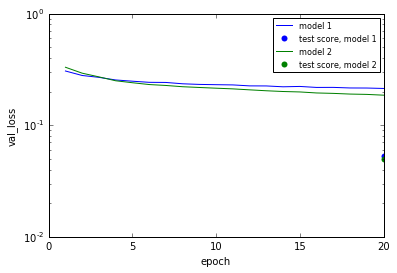

In [17]:
filename = 'output_dir/largefilters_sigmoid.txt'
#filename = 'models/good_models/FCNforkskip_imggen_lmbda0.0e+00.txt'

epoch_score, N_models = [], 0
lines = open(filename, 'r').readlines()
for line in lines:
    if "val_loss:" in line:
        epoch_score.append(float(line.split('val_loss:')[1]))
    elif "Test Score is" in line:
        N_models += 1
        test_score, n_epochs = float(line.split('Test Score is')[1]), len(epoch_score)
        p = plt.plot(np.arange(n_epochs)+1, epoch_score, label='model %d'%N_models)
        plt.plot(n_epochs, test_score, 'o', color=p[0].get_color(), mew=0, label='test score, model %d'%N_models)
        plt.legend(fontsize=8, numpoints=1)
        epoch_score = []

plt.plot(np.arange(len(epoch_score))+1, epoch_score)
plt.xlabel('epoch')
plt.ylabel('val_loss')
plt.yscale('log')

## Custom Image Generator

In [24]:
def custom_image_generator(data, target, batch_size=2):
    np.random.seed(0)
    L, W = data[0].shape[0], data[0].shape[1]
    while True:
        for i in range(0, len(data), batch_size):
            d, t = data[i:i+batch_size].copy(), target[i:i+batch_size].copy() #most efficient for memory?
            
            #horizontal/vertical flips
            for j in np.where(np.random.randint(0,2,batch_size)==1)[0]:
                d[j], t[j] = np.fliplr(d[j]), np.fliplr(t[j])                 #left/right 
            for j in np.where(np.random.randint(0,2,batch_size)==1)[0]:
                d[j], t[j] = np.flipud(d[j]), np.flipud(t[j])                 #up/down
                
            #random up/down and left/right pixel shifts
            npix = 10
            h = np.random.randint(-npix,npix+1,batch_size)                         #horizontal shift
            v = np.random.randint(-npix,npix+1,batch_size)                         #vertical shift
            r = np.random.randint(0,4,batch_size)                                  #random 90 degree rot
            for j in range(batch_size):
                d[j] = np.pad(d[j], ((npix,npix),(npix,npix),(0,0)), mode='constant')[npix+h[j]:L+h[j]+npix,npix+v[j]:W+v[j]+npix,:] 
                t[j] = np.pad(t[j], (npix,), mode='constant')[npix+h[j]:L+h[j]+npix,npix+v[j]:W+v[j]+npix]
                d[j], t[j] = np.rot90(d[j],r[j]), np.rot90(t[j],r[j])
            yield (d, t)

In [25]:
#Manipulate the first n_images in the training set
batch_size = 10
images = []
for batch in custom_image_generator(train_data,train_target,batch_size):
    images.append(batch)
    break 

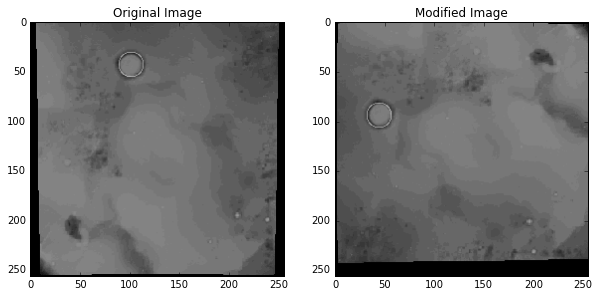

In [26]:
i=7      #i < n_images

f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=[10, 10])

ax1.imshow(train_data[i].reshape(dim,dim), origin='upper', cmap="Greys_r")
ax1.imshow(train_target[i], origin='upper', cmap="Greys_r",alpha=0.4)
ax1.set_title('Original Image')

ax2.imshow(images[0][0][i].reshape(dim,dim), origin='upper', cmap="Greys_r")
ax2.imshow(images[0][1][i], origin='upper', cmap="Greys_r",alpha=0.4)
ax2.set_title('Modified Image')

#plt.savefig('sample.png')

## Bilinear Upsampling Testing

In [12]:
from keras.models import Sequential, Model
from keras.layers.core import Dense, Dropout, Flatten, Reshape
from keras.layers import AveragePooling2D, merge, Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D
from keras.regularizers import l2
from keras import backend as K
K.set_image_dim_ordering('tf')
from utils.BilinearUpSampling import *

In [38]:
img_input = Input(batch_shape=(None, 300, 300, 3))
x = BilinearUpSampling2D(size=(2, 2))(img_input)
#x = UpSampling2D(size=(2, 2))(img_input)
model = Model(input=img_input, output=x)

In [39]:
#test_pred = model.predict(test_target.reshape(50,300,300,1)).reshape(50,600,600)
test_pred = model.predict(test_data)

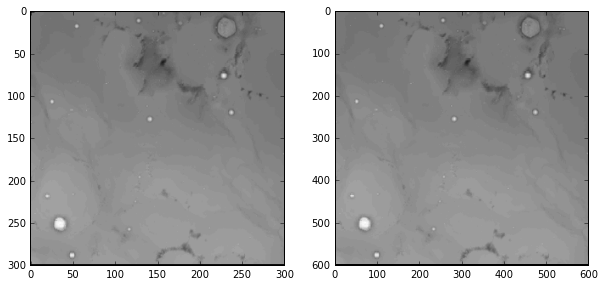

In [40]:
i=0
f, (ax1, ax2) = plt.subplots(1, 2, figsize=[10, 6])
ax1.imshow(test_data[i], origin='upper', cmap="Greys_r")
ax2.imshow(test_pred[i], origin='upper', cmap="Greys_r")

# Old

In [5]:
ext = "rings"    #rings or circlerings
train_data=np.load('training_set/train_data_%s_sample.npy'%ext).astype('float32')
train_target=np.load('training_set/train_target_%s_sample.npy'%ext).astype('float32')
test_data=np.load('test_set/test_data_%s_sample.npy'%ext).astype('float32')
test_target=np.load('test_set/test_target_%s_sample.npy'%ext).astype('float32')

IOError: [Errno 2] No such file or directory: 'training_set/train_data_rings_sample.npy'